In [33]:
from datetime import datetime
import time,pytz
import os, glob, subprocess, sys, uuid
from tqdm import tqdm

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

import keras

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

GLOBAL_RANDOM_SEED = 42

random.seed(GLOBAL_RANDOM_SEED)
np.random.seed(GLOBAL_RANDOM_SEED)
tf.random.set_seed(GLOBAL_RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
initializer = keras.initializers.GlorotUniform(seed=GLOBAL_RANDOM_SEED)

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


I0000 00:00:1757859148.170787   40291 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5223 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [34]:
# ========== LOAD & CLEAN ==========
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

files = [
    ("data/processed.cleveland.data", "cleveland"),
    ("data/processed.hungarian.data", "hungarian"),
    ("data/processed.switzerland.data", "switzerland"),
    ("data/processed.va.data", "va")
]

# Load data with source tracking
dfs = []
for file_path, source in files:
    temp_df = pd.read_csv(file_path, names=column_names, na_values='?', header=None)
    temp_df['source'] = source
    dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True)

# Convert columns to numeric, binarize target
for col in column_names:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print(df.describe())

              age         sex          cp    trestbps        chol         fbs  \
count  920.000000  920.000000  920.000000  861.000000  890.000000  830.000000   
mean    53.510870    0.789130    3.250000  132.132404  199.130337    0.166265   
std      9.424685    0.408148    0.930969   19.066070  110.780810    0.372543   
min     28.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%     47.000000    1.000000    3.000000  120.000000  175.000000    0.000000   
50%     54.000000    1.000000    4.000000  130.000000  223.000000    0.000000   
75%     60.000000    1.000000    4.000000  140.000000  268.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  603.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  918.000000  865.000000  865.000000  858.000000  611.000000  309.000000   
mean     0.604575  137.545665    0.389595    0.878788    1.770867    0.676375   
std      0.805827   25.9262

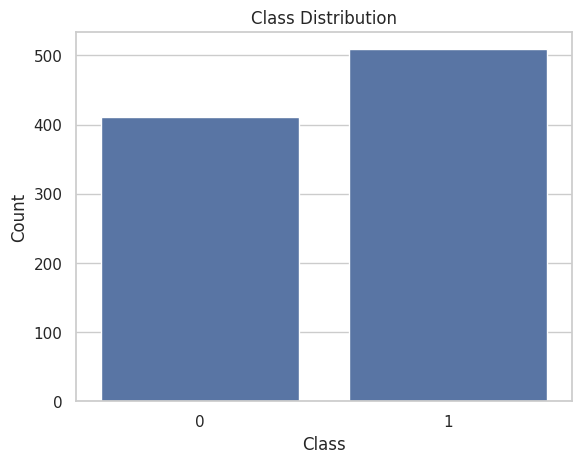

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='target', data=df)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [36]:
# from sklearn.base import BaseEstimator, ClassifierMixin, clone
# from sklearn.model_selection import cross_val_predict, StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import StackingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# import numpy as np

# # -------- TieredStackingClassifier --------
# class TieredStackingClassifier(BaseEstimator, ClassifierMixin):
#     def __init__(self, groups, meta_estimators=None, final_estimator=None, cv=5, random_state=None):
#         self.groups = groups
#         self.meta_estimators = meta_estimators or {}
#         self.final_estimator = final_estimator or LogisticRegression(max_iter=1000)
#         self.cv = cv
#         self.random_state = random_state
#         self._group_models = {}

#     def _make_group_stack(self, estimators, meta_estimator):
#         return StackingClassifier(
#             estimators=estimators,
#             final_estimator=clone(meta_estimator),
#             cv=self.cv,
#             passthrough=False,
#             n_jobs=-1
#         )

#     def fit(self, X, y):
#         skf = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)
#         group_oof = []
#         group_names = []
#         for gname, estimators in self.groups.items():
#             meta = self.meta_estimators.get(gname, LogisticRegression(max_iter=1000))
#             stack_clf = self._make_group_stack(estimators, meta)
#             # produce true out-of-fold probabilities for the positive class
#             oof = cross_val_predict(clone(stack_clf), X, y, cv=skf, method='predict_proba', n_jobs=-1)
#             if oof.ndim == 2:
#                 oof_pos = oof[:, 1].reshape(-1, 1)
#             else:
#                 oof_pos = oof.reshape(-1, 1)
#             group_oof.append(oof_pos)
#             group_names.append(gname)
#             # fit on full data for inference
#             fitted = clone(stack_clf).fit(X, y)
#             self._group_models[gname] = fitted

#         final_X = np.hstack(group_oof)
#         self._final_features_ = group_names
#         self.final_estimator_ = clone(self.final_estimator).fit(final_X, y)
#         return self

#     def predict_proba(self, X):
#         proba_cols = []
#         for gname in self._final_features_:
#             model = self._group_models[gname]
#             p = model.predict_proba(X)[:, 1].reshape(-1, 1)
#             proba_cols.append(p)
#         meta_X = np.hstack(proba_cols)
#         return self.final_estimator_.predict_proba(meta_X)

#     def predict(self, X):
#         proba = self.predict_proba(X)[:, 1]
#         return (proba >= 0.5).astype(int)


# # -------- CV-weighted voting builder (selector-aware) --------
# def build_cv_weighted_voting_for_selector(base_learners, selector_steps, X, y, cv=3, scoring='roc_auc'):
#     """
#     base_learners: list of (name, estimator) - raw estimators, not pipelines
#     selector_steps: list of transformer tuples (same as your sel_steps)
#     X,y: training data (full)
#     Returns: VotingClassifier with weights computed on selector-aware pipelines
#     """
#     from sklearn.pipeline import Pipeline as SklearnPipeline
#     from imblearn.pipeline import Pipeline as ImbPipelineLocal
#     from sklearn.model_selection import cross_val_score
#     from imblearn.over_sampling import SMOTE
#     from sklearn.preprocessing import StandardScaler
#     import numpy as np
#     scores = []
#     for name, est in base_learners:
#         # pipeline that mirrors what you'll run during training: scaler + selector + smote + estimator
#         pipe = ImbPipelineLocal([("scaler", StandardScaler())] + selector_steps + [("smote", SMOTE(random_state=GLOBAL_RANDOM_SEED)), ("model", clone(est))])
#         s = cross_val_score(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
#         mean_score = np.mean(s)
#         scores.append(mean_score)
#         print(f"[CV weight] {name}: mean {scoring} = {mean_score:.4f}")
#     scores = np.array(scores)
#     if scores.sum() == 0:
#         weights = [1.0] * len(scores)
#     else:
#         weights = (scores / scores.sum()).tolist()
#     from sklearn.ensemble import VotingClassifier
#     voting = VotingClassifier(estimators=base_learners, voting='soft', weights=weights, n_jobs=-1)
#     return voting, weights


# # -------- Hybrid stacking builder (RF + XGB) --------
# def build_hybrid_stacking(random_state=None):
#     hybrid_estimators = [
#         ('rf', RandomForestClassifier(n_estimators=200, random_state=random_state)),
#         ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=random_state))
#     ]
#     final_meta = LogisticRegression(max_iter=1000)
#     stacking = StackingClassifier(estimators=hybrid_estimators, final_estimator=final_meta, passthrough=True, cv=5, n_jobs=-1)
#     return stacking

In [37]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from skrebate import ReliefF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.base import BaseEstimator, ClassifierMixin

class AdvancedStackingEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, base_learners=None, meta_learner=None):
        self.base_learners = base_learners
        self.meta_learner = meta_learner

    def fit(self, X, y):
        self.y_train_ = y
        self.X_train_ = X
        # nothing else to do for now
        return self

    def predict(self, X):
        preds, _ = cross_validated_stacking(self.base_learners, self.meta_learner,
                                            self.X_train_, self.y_train_, X)
        return preds

    def predict_proba(self, X):
        _, probs = cross_validated_stacking(self.base_learners, self.meta_learner,
                                            self.X_train_, self.y_train_, X)
        return np.vstack([1-probs, probs]).T

def cross_validated_stacking(base_learners, meta_learner, X_train, y_train, X_test, n_folds=5):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=GLOBAL_RANDOM_SEED)
    meta_features_train = np.zeros((X_train.shape[0], len(base_learners)))
    meta_features_test = np.zeros((X_test.shape[0], len(base_learners)))

    for i, (name, model) in enumerate(base_learners):
        fold_preds = np.zeros(X_train.shape[0])
        test_preds = np.zeros((X_test.shape[0], n_folds))
        for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
            X_tr, X_val = X_train[train_idx], X_train[valid_idx]
            y_tr, y_val = y_train[train_idx], y_train[valid_idx]
            model.fit(X_tr, y_tr)
            fold_preds[valid_idx] = model.predict_proba(X_val)[:, 1]
            test_preds[:, fold_idx] = model.predict_proba(X_test)[:, 1]

        meta_features_train[:, i] = fold_preds
        meta_features_test[:, i] = test_preds.mean(axis=1)

    meta_learner.fit(meta_features_train, y_train)
    final_preds = meta_learner.predict(meta_features_test)
    final_probs = meta_learner.predict_proba(meta_features_test)[:, 1]
    return final_preds, final_probs

# ======== IMPUTATION ========
dfs_imputed = []
for source in df['source'].unique():
    temp = df[df['source'] == source].copy()
    numeric_cols = temp.select_dtypes(include=[np.number]).columns.drop('target')
    imputer = KNNImputer(n_neighbors=min(5, len(temp)-1))
    temp[numeric_cols] = imputer.fit_transform(temp[numeric_cols])
    dfs_imputed.append(temp)

df = pd.concat(dfs_imputed, ignore_index=True)
df = pd.get_dummies(df, columns=['source'], prefix='src')
df = df.fillna(df.median())

# ======== SPLIT ========
X = df.drop('target', axis=1)
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=GLOBAL_RANDOM_SEED
)

# ======== BASE LEARNERS & ENSEMBLES ========
base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('xgb', XGBClassifier(eval_metric='logloss'))
]

voting_clf = VotingClassifier(estimators=base_learners, voting='soft', n_jobs=-1)
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(),
                                  passthrough=True, cv=5, n_jobs=-1)

# ======== MODELS & SELECTORS ========
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "DecTree": DecisionTreeClassifier(),
    "RandForest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Voting": voting_clf,
    "Stacking": stacking_clf,
}

selectors = {
    "None": [],
    "Chi2": [("nonneg_shift", FunctionTransformer(lambda x: x - x.min(axis=0))),
             ("select", SelectKBest(chi2, k=10))],
    "MutInfo": [("select", SelectKBest(mutual_info_classif, k=9))],
    "ReliefF": [("select", ReliefF(n_features_to_select=9))],
    "PCA": [("reduce", PCA(n_components=10))]
}

# ======== HYPERPARAMETER GRIDS ========
param_grids = {
    "LogReg": {"model__C": uniform(0.1, 10), "model__penalty": ['l2', None],
               "model__solver": ['newton-cg', 'lbfgs', 'sag']},
    "DecTree": {"model__max_depth": [None, 5, 10, 15, 20, 25], "model__min_samples_split": randint(2, 20),
                "model__min_samples_leaf": randint(1, 10), "model__max_features": ['sqrt', 'log2', None]},
    "RandForest": {"model__n_estimators": [100, 200, 300], "model__max_depth": [None, 10, 20, 30],
                   "model__min_samples_split": [2, 5, 10], "model__min_samples_leaf": [1, 2, 4],
                   "model__max_features": ['sqrt', 'log2']},
    "SVM": {"model__C": uniform(0.1, 10), "model__kernel": ['linear', 'rbf', 'poly'], "model__gamma": ['scale']},
    "KNN": {"model__n_neighbors": randint(3, 15), "model__weights": ['uniform', 'distance'], "model__p": [1, 2]},
    "XGBoost": {"model__n_estimators": [100, 200, 300], "model__max_depth": [3, 6, 9],
                "model__learning_rate": [0.01, 0.05, 0.1], "model__subsample": [0.8, 0.9, 1.0],
                "model__colsample_bytree": [0.8, 0.9, 1.0]},
    "Voting": {"model__weights": [[1, 1, 1, 1, 1, 1], [1, 1, 2, 1, 1, 2], [1, 1, 3, 1, 1, 3]]}
}

# ======== FEATURE EXTRACTION ========
def get_selected_features(pipe, X_train):
    try:
        if "select" in pipe.named_steps:
            sel = pipe.named_steps["select"]
            if hasattr(sel, "get_support"):
                return X_train.columns[sel.get_support()].tolist()
            if hasattr(sel, "top_features_"):
                return [X_train.columns[i] for i in sel.top_features_]
        if "reduce" in pipe.named_steps:
            pc = pipe.named_steps["reduce"]
            n = getattr(pc, "n_components_", getattr(pc, "n_components", None))
            if n: return [f"PC{i+1}" for i in range(n)]
    except Exception as e:
        return [f"[Error: {e}]"]
    return ["[No selector]"]

# ======== MAIN LOOP WITH DYNAMIC ENSEMBLES ========
results = []

for sel_name, sel_steps in selectors.items():
    print(f"\n=== Selector: {sel_name} ===")
    
    # # Build selector-aware WeightedVoting
    # weighted_voting_clf, computed_weights = build_cv_weighted_voting_for_selector(
    #     base_learners=base_learners, selector_steps=sel_steps,
    #     X=X_train, y=y_train, cv=3, scoring='roc_auc'
    # )
    # print("Computed selector-aware weights:", computed_weights)
    

    # skip pipeline fit, call function directly
    base_for_stack = [
        ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=2, max_features='sqrt', random_state=GLOBAL_RANDOM_SEED)),
        ('xgb', XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, use_label_encoder=False, eval_metric='logloss', random_state=GLOBAL_RANDOM_SEED)),
        ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=GLOBAL_RANDOM_SEED)),
        ('svc', SVC(C=1.0, kernel='rbf', probability=True, random_state=GLOBAL_RANDOM_SEED))
    ]
    meta_lr = LogisticRegression(C=1.0, max_iter=500, solver='liblinear')
    # Build per-selector models dict
    models_to_run = models.copy()
    # models_to_run["WeightedVoting"] = weighted_voting_clf
    # models_to_run["TieredStacking"] = TieredStackingClassifier(
    #     groups={
    #         "linear": [('lr', LogisticRegression(max_iter=1000)), ('svm_lin', SVC(kernel='linear', probability=True))],
    #         "tree": [('dt', DecisionTreeClassifier()),
    #                  ('rf', RandomForestClassifier(n_estimators=200, random_state=GLOBAL_RANDOM_SEED)),
    #                  ('xgb', XGBClassifier(eval_metric='logloss'))],
    #         "distance": [('knn', KNeighborsClassifier())]
    #     },
    #     meta_estimators={
    #         "linear": LogisticRegression(max_iter=1000),
    #         "tree": LogisticRegression(max_iter=1000),
    #         "distance": LogisticRegression(max_iter=1000)
    #     },
    #     final_estimator=LogisticRegression(max_iter=1000),
    #     cv=5, random_state=GLOBAL_RANDOM_SEED
    # )
    models_to_run["AdvancedStacking"] = AdvancedStackingEstimator(base_for_stack, meta_lr)
    # models_to_run["HybridStacking"] = build_hybrid_stacking(random_state=GLOBAL_RANDOM_SEED)
    
    for model_name, model in models_to_run.items():
        print(f"Processing: {sel_name} + {model_name}")
        steps = [("scaler", StandardScaler())] + sel_steps + [("smote", SMOTE(random_state=GLOBAL_RANDOM_SEED)), ("model", model)]
        pipe = ImbPipeline(steps)
        
        if model_name == "AdvancedStacking":
            y_pred, y_proba = cross_validated_stacking(base_for_stack, meta_lr, X_train.values, y_train, X_test.values)
            tuned = False
            tuning_info = "No tuning performed"
            selected_features = X_train.columns.tolist() if sel_name=="None" else get_selected_features(pipe, X_train)
        if model_name in param_grids:
            search_cls = GridSearchCV if model_name == "Voting" else RandomizedSearchCV
            search_args = {
                "estimator": pipe,
                "param_distributions" if model_name != "Voting" else "param_grid": param_grids[model_name],
                "cv": 3, "scoring": "roc_auc", "n_jobs": -1
            }
            search = search_cls(**search_args)
            search.fit(X_train, y_train)
            best_pipe = search.best_estimator_
            y_pred = best_pipe.predict(X_test)
            y_proba = best_pipe.predict_proba(X_test)[:, 1]
            tuned = True
            tuning_info = {"best_params": search.best_params_, "best_score": search.best_score_}
            current_pipe = best_pipe
        else:
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            y_proba = pipe.predict_proba(X_test)[:, 1]
            tuned = False
            tuning_info = {}
            current_pipe = pipe
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba)
        
        selected_features = X_train.columns.tolist() if sel_name=="None" else get_selected_features(current_pipe, X_train)
        
        results.append({
            "Selector": sel_name,
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "AUC": auc,
            "Selected Features": selected_features,
            "Tuned": tuned,
            "Tuning Info": tuning_info if tuned else "No tuning performed"
        })

# ======== SAVE & DISPLAY ========
df_results = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
print(df_results.sort_values(by="AUC", ascending=False).to_string(index=False))
df_results.to_csv("classification_tuning_results.csv", index=False)
print("\nResults saved to CSV.")


=== Selector: None ===
Processing: None + LogReg


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.py

Processing: None + DecTree
Processing: None + RandForest
Processing: None + SVM
Processing: None + KNN
Processing: None + XGBoost
Processing: None + Voting
Processing: None + Stacking
Processing: None + AdvancedStacking


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:42:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:42:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:42:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ar


=== Selector: Chi2 ===
Processing: Chi2 + LogReg
Processing: Chi2 + DecTree


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.py

Processing: Chi2 + RandForest
Processing: Chi2 + SVM
Processing: Chi2 + KNN
Processing: Chi2 + XGBoost
Processing: Chi2 + Voting
Processing: Chi2 + Stacking
Processing: Chi2 + AdvancedStacking


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ar


=== Selector: MutInfo ===
Processing: MutInfo + LogReg


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.py

Processing: MutInfo + DecTree
Processing: MutInfo + RandForest
Processing: MutInfo + SVM
Processing: MutInfo + KNN
Processing: MutInfo + XGBoost
Processing: MutInfo + Voting
Processing: MutInfo + Stacking
Processing: MutInfo + AdvancedStacking


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:43:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ar


=== Selector: ReliefF ===
Processing: ReliefF + LogReg


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.py

Processing: ReliefF + DecTree
Processing: ReliefF + RandForest
Processing: ReliefF + SVM
Processing: ReliefF + KNN
Processing: ReliefF + XGBoost
Processing: ReliefF + Voting
Processing: ReliefF + Stacking
Processing: ReliefF + AdvancedStacking


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ar


=== Selector: PCA ===
Processing: PCA + LogReg
Processing: PCA + DecTree


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.py

Processing: PCA + RandForest
Processing: PCA + SVM
Processing: PCA + KNN
Processing: PCA + XGBoost
Processing: PCA + Voting
Processing: PCA + Stacking
Processing: PCA + AdvancedStacking


/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/arash/.pyenv/versions/tf312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:46:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ar

Selector            Model  Accuracy  Precision   Recall  F1 Score      AUC                                                                                                                             Selected Features  Tuned                                                                                                                                                                                          Tuning Info
 ReliefF          XGBoost  0.858696   0.895833 0.843137  0.868687 0.940698 [exang, cp, ca, thal, oldpeak, src_hungarian, chol, src_cleveland, slope, src_switzerland, src_va, thalach, age, sex, restecg, trestbps, fbs]   True        {'best_params': {'model__subsample': 0.9, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.9}, 'best_score': 0.8805832679193445}
    None       RandForest  0.864130   0.873786 0.882353  0.878049 0.937470 [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, th

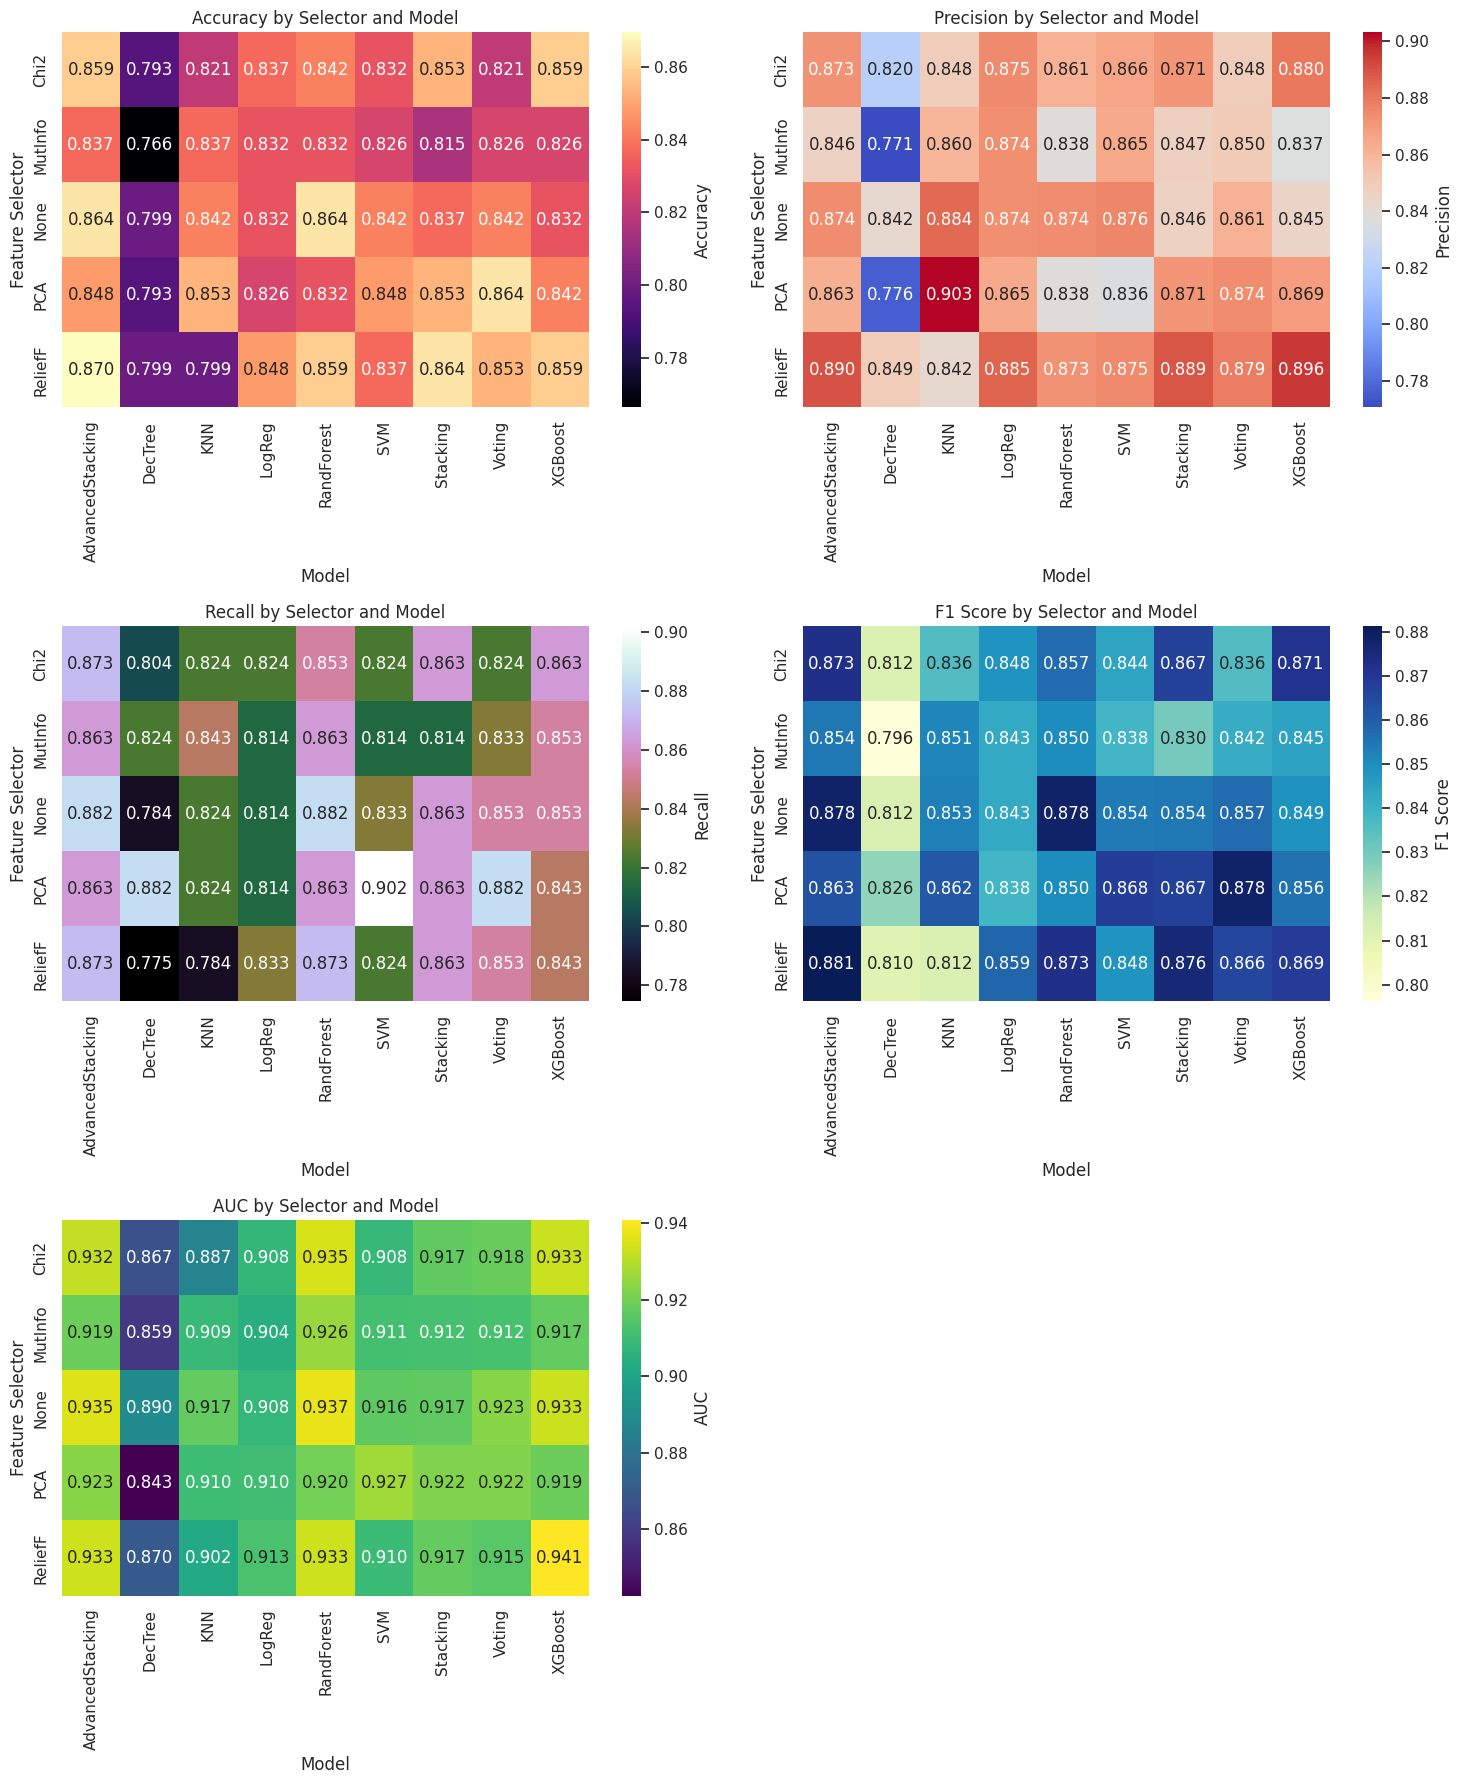

In [38]:
# ========== HITMAPS ==========
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
cmap_dict = {
    "Accuracy": "magma",
    "Precision": "coolwarm",
    "Recall": "cubehelix",
    "F1 Score": "YlGnBu",
    "AUC": "viridis"
}

plt.figure(figsize=(15, 18))
sns.set_theme(style="whitegrid")

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    metric_matrix = df_results.pivot(index="Selector", columns="Model", values=metric)
    sns.heatmap(metric_matrix, annot=True, fmt=".3f", cmap=cmap_dict[metric], cbar_kws={'label': metric})
    plt.title(f"{metric} by Selector and Model")
    plt.xlabel("Model")
    plt.ylabel("Feature Selector")

plt.tight_layout()
plt.show()

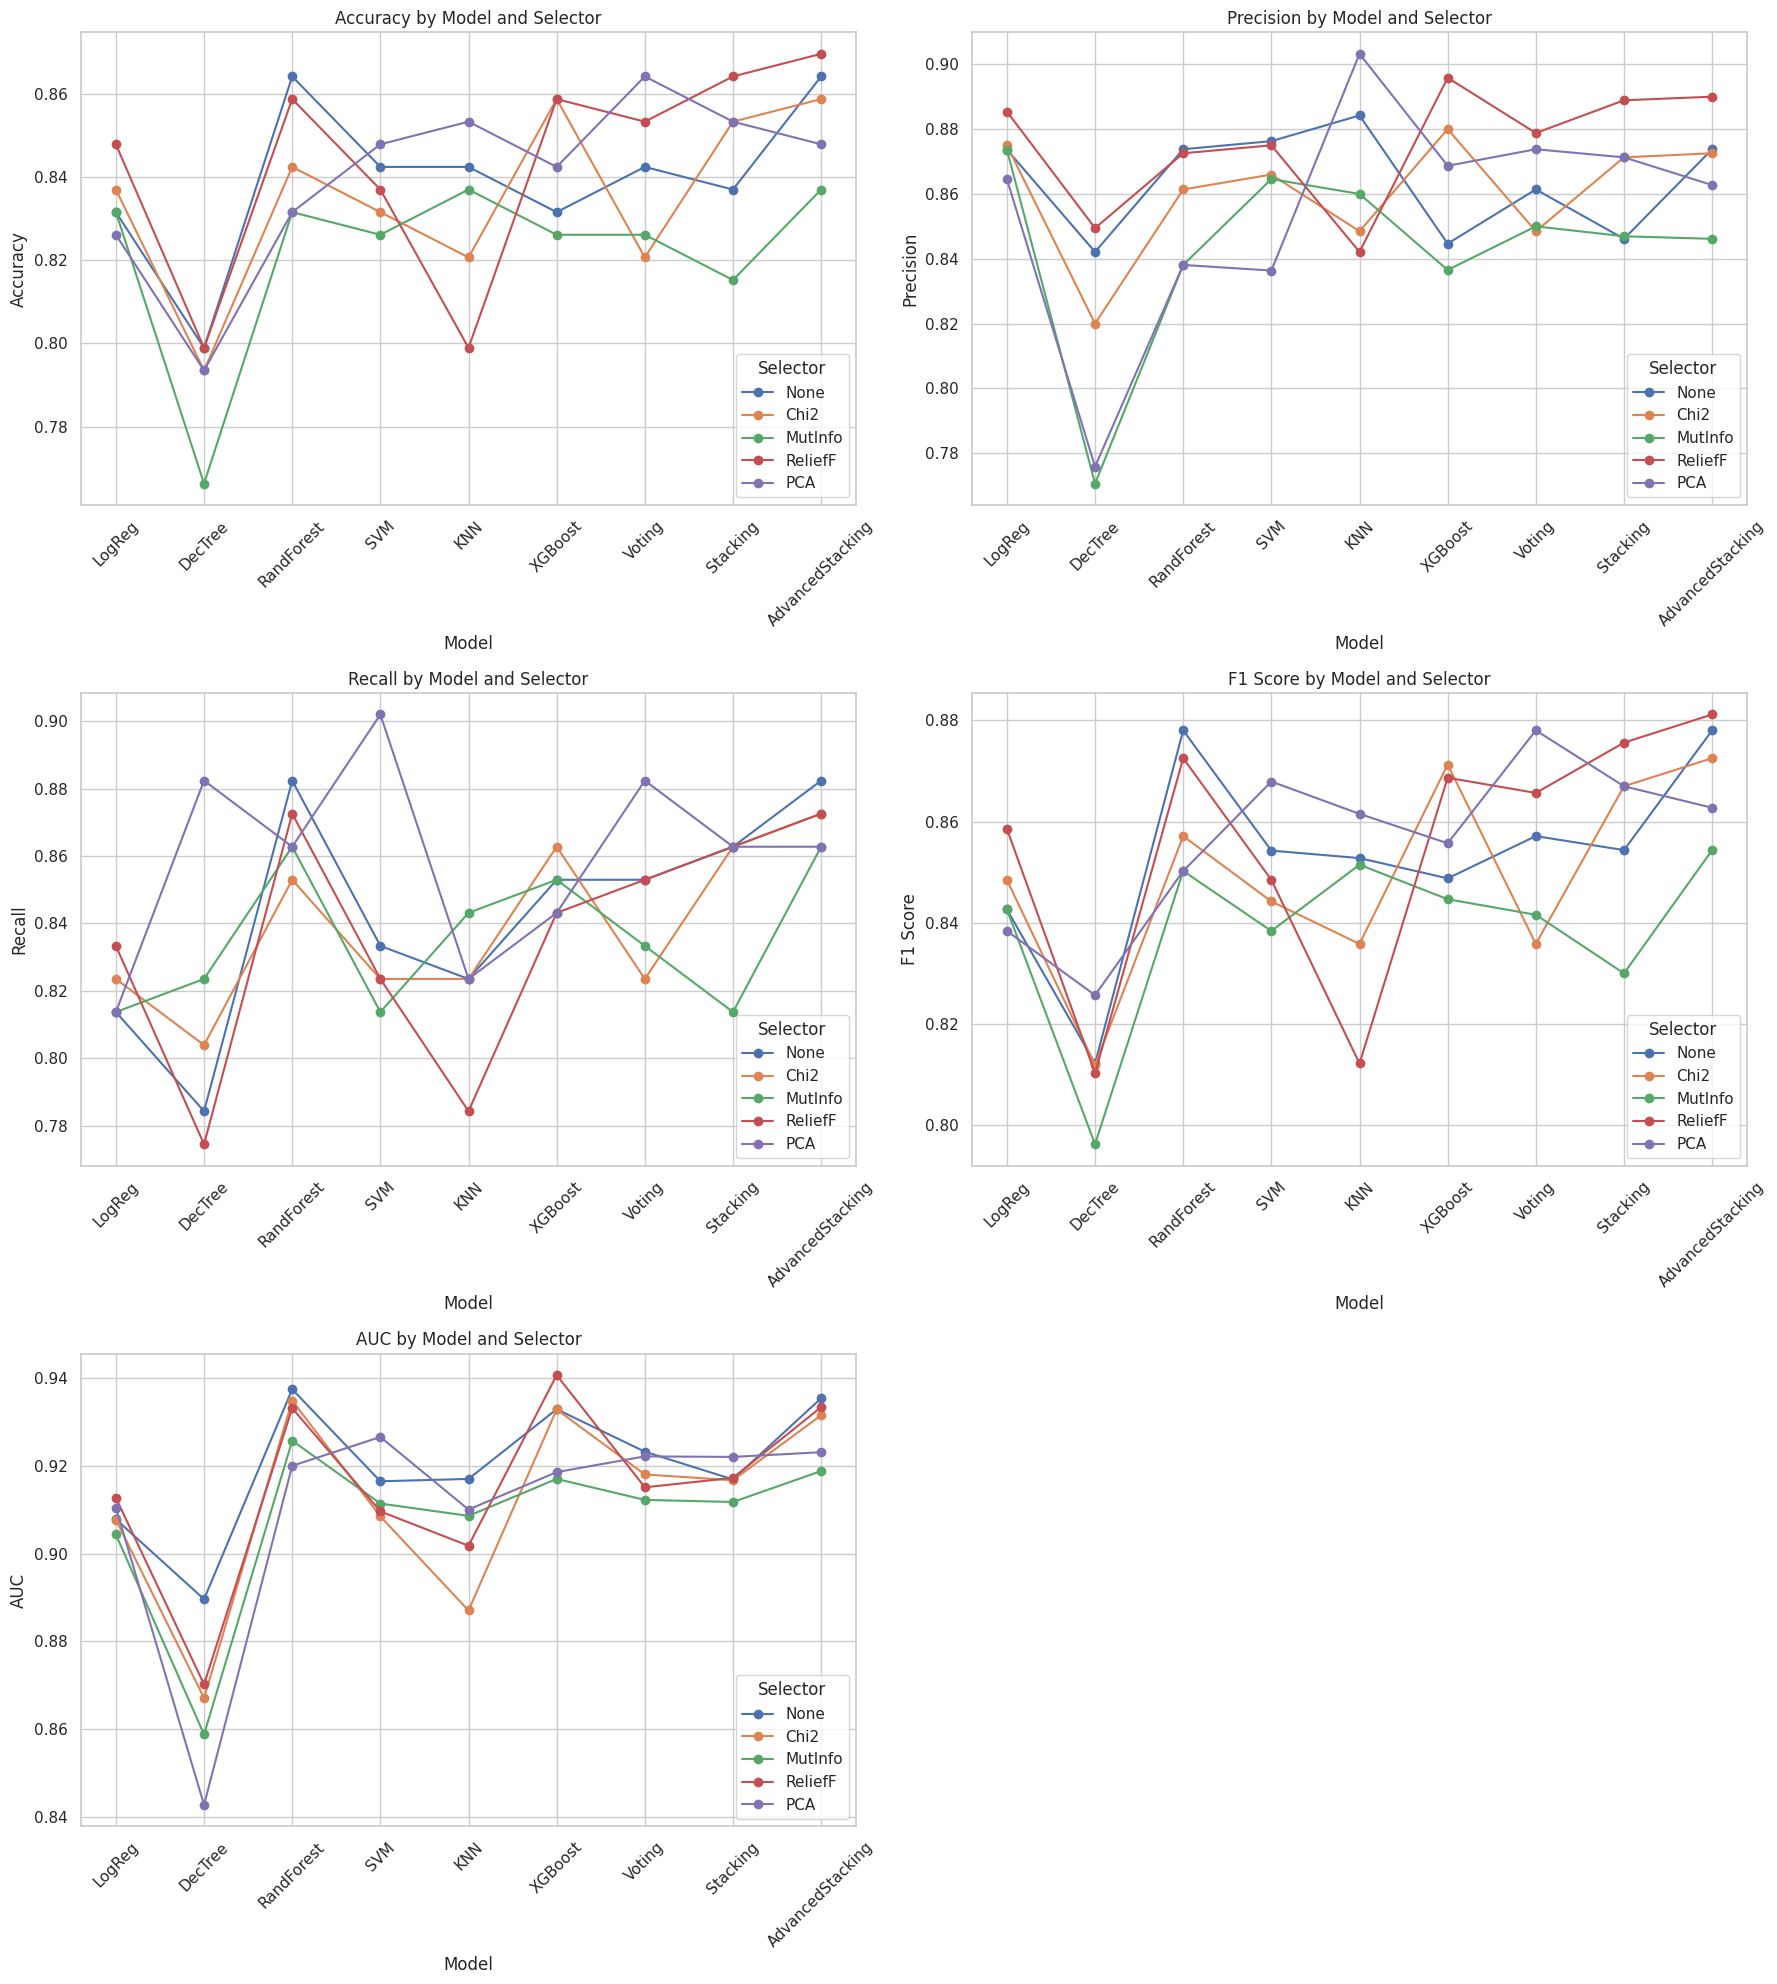

In [39]:
import matplotlib.pyplot as plt

# Metrics to visualize
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]

# List of unique models and selectors for ordering
models = df_results['Model'].unique()
selectors = df_results['Selector'].unique()

plt.figure(figsize=(18, 20))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    
    for sel in selectors:
        subset = df_results[df_results['Selector'] == sel]
        # Ensure consistent order by model
        subset = subset.set_index('Model').reindex(models)
        plt.plot(models, subset[metric], marker='o', label=sel)
    
    plt.title(f"{metric} by Model and Selector")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Selector")

plt.tight_layout()
plt.show()